# Insper Jr. 

# Análise de Dados para R. Amaral Office
___


In [1]:
import pandas as pd
import os
import math
from statsmodels.tsa.seasonal import STL

%matplotlib inline
import matplotlib.pyplot as plt


## LEITURA DA BASE DE DADOS

In [2]:
filename = 'Base de Dados R. Amaral Office.xlsx'

if filename in os.listdir():
    print(f'Parece que o arquivo {filename} está na mesma pasta do notebook da avaliação, yay!\n')
    
else:
    print(f'Não encontrei o arquivo {filename}.\n'
          f'O notebook e os arquivos de dados desta avaliação devem ser salvos dentro da mesma pasta no seu computador.\n')

Parece que o arquivo Base de Dados R. Amaral Office.xlsx está na mesma pasta do notebook da avaliação, yay!



In [3]:
# Carregando os dados
df = pd.read_excel(filename)
df.head()


,id_pedido,nome_cliente,modo_envio,estado,vendas,quantidade,desconto,lucro,segmento,região,...,dia_pedido,dia_semana_pedido,mes_pedido,ano_pedido,dia_envio,mes_envio,ano_envio,data_pedido,mes_ano,tempo_preparacao
0,1,Muhammed MacIntyre,Expresso,Paraná,825.174,9,0.30,-117.8820,Corporativo,Sul,...,4,Domingo,9,2016,6,9,2016,42617,42617,2
1,2,Ruben Dartt,Normal,São Paulo,411.332,4,0.15,-4.8392,Consumidor,Sudeste,...,5,Sexta-feira,9,2014,9,9,2014,41887,41887,4
2,3,Liz Pelletier,Mesmo Dia,São Paulo,411.332,4,0.15,-4.8392,Home Office,Sudeste,...,28,Quinta-feira,11,2013,28,11,2013,41606,41606,0
3,4,Liz Pelletier,Expresso,Amapá,241.960,2,0.00,33.8744,Consumidor,Norte,...,30,Segunda-feira,5,2016,31,5,2016,42520,42520,1
4,5,Liz Pelletier,Normal,Sergipe,341.960,2,0.00,78.6508,Home Office,Nordeste,...,31,Terça-feira,12,2013,7,1,2014,41639,41639,7


## PREPARO DA BASE DE DADOS

In [4]:
type(df)
df.dtypes

id_pedido              int64
nome_cliente          object
modo_envio            object
estado                object
vendas               float64
quantidade             int64
desconto             float64
lucro                float64
segmento              object
região                object
subcategoria          object
categoria             object
dia_pedido             int64
dia_semana_pedido     object
mes_pedido             int64
ano_pedido             int64
dia_envio              int64
mes_envio              int64
ano_envio              int64
data_pedido            int64
mes_ano                int64
tempo_preparacao       int64
dtype: object

## 5. Correlação de Eficiencia Operacinal e Logística com Promoções

In [10]:
#DO CÓDIGO DE OPERACIONAL E LOGÍSTICA 

df['data_pedido'] = pd.to_datetime(
    dict(year=df['ano_pedido'], month=df['mes_pedido'], day=df['dia_pedido'])
)
df['data_envio'] = pd.to_datetime(
    dict(year=df['ano_envio'], month=df['mes_envio'], day=df['dia_envio'])
)


df['dias_transporte'] = (df['data_envio'] - df['data_pedido']).dt.days
X = 5
df['atraso'] = df['dias_transporte'] > X

In [11]:
#pedido em promoção
df['promocao'] = df['desconto'] > 0

# promo vs não-promo
metrics_prom = (
    df
    .groupby('promocao')
    .agg(
        pedidos            = ('id_pedido',       'count'),
        tempo_medio_prep   = ('tempo_preparacao','mean'),
        taxa_atraso        = ('atraso',          'mean')
    )
    .reset_index()
)

print("Comparativo Promo vs Não-Promo:\n", metrics_prom)

# dias de pico de promo (top 10 % em volume)
promo_daily = (
    df[df['promocao']]
    .groupby('data_pedido')
    .size()
    .reset_index(name='count_promo')
)
threshold = promo_daily['count_promo'].quantile(0.90)
peak_days = promo_daily.loc[promo_daily['count_promo'] > threshold, 'data_pedido']

# dia de pico
df['promo_peak'] = df['data_pedido'].isin(peak_days)

# Métricas: pico vs não-pico
metrics_peak = (
    df
    .groupby('promo_peak')
    .agg(
        pedidos            = ('id_pedido',       'count'),
        tempo_medio_prep   = ('tempo_preparacao','mean'),
        taxa_atraso        = ('atraso',          'mean')
    )
    .reset_index()
)
print("\nComparativo Dias de Pico vs Dias Normais:\n", metrics_peak)

Comparativo Promo vs Não-Promo:
    promocao  pedidos  tempo_medio_prep  taxa_atraso
0     False     4798          3.987286     0.196123
1      True     5196          3.931293     0.169938

Comparativo Dias de Pico vs Dias Normais:
    promo_peak  pedidos  tempo_medio_prep  taxa_atraso
0       False     8164          3.960436     0.175404
1        True     1830          3.948087     0.214208


In [12]:
metrics_pedido = (
    df
    .groupby('promocao')
    .agg(
        num_pedidos           = ('id_pedido', 'count'),
        total_vendas          = ('vendas',     'sum'),
        media_vendas_por_ped  = ('vendas',     'mean')
    )
    .reset_index()
)
print("Vendas por pedido (Promo vs. Não-Promo):")
print(metrics_pedido)


daily = (
    df
    .groupby('data_pedido')
    .agg(
        total_vendas   = ('vendas',   'sum'),
        pedidos_promos = ('promocao', 'sum')
    )
    .reset_index()
)

daily['dia_com_promocao'] = daily['pedidos_promos'] > 0

# Comparação com vendas médias diárias
metrics_diario = (
    daily
    .groupby('dia_com_promocao')
    .agg(
        dias                     = ('data_pedido', 'count'),
        vendas_media_diaria      = ('total_vendas', 'mean'),
        vendas_total_no_periodo  = ('total_vendas', 'sum'),
    )
    .reset_index()
)
print("\nVendas diárias (Dias com Promo vs. Sem Promo):")
print(metrics_diario)

Vendas por pedido (Promo vs. Não-Promo):
   promocao  num_pedidos  total_vendas  media_vendas_por_ped
0     False         4798  1.087908e+06            226.742074
1      True         5196  1.209292e+06            232.735256

Vendas diárias (Dias com Promo vs. Sem Promo):
   dia_com_promocao  dias  vendas_media_diaria  vendas_total_no_periodo
0             False   154           609.760519             9.390312e+04
1              True  1083          2034.439280             2.203298e+06


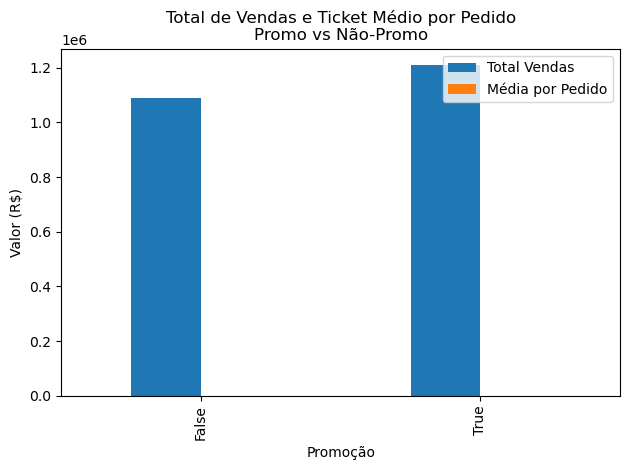

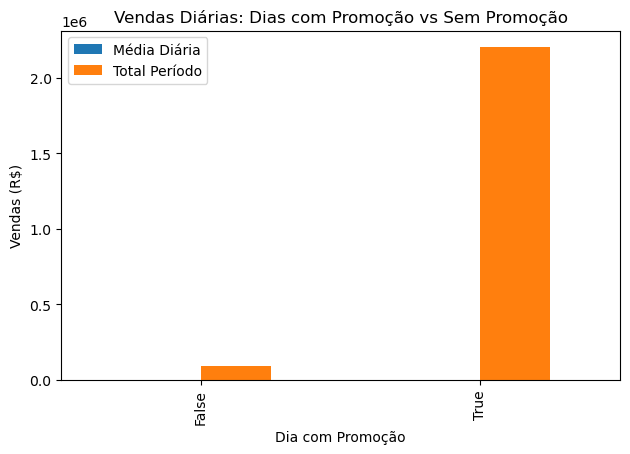

In [13]:
#Pivot para gráfico
pivot1 = metrics_pedido.set_index('promocao')[['total_vendas', 'media_vendas_por_ped']]

# Gráfico 1: Vendas totais e ticket médio por pedido
fig, ax = plt.subplots()
pivot1.plot(kind='bar', ax=ax)
ax.set_title('Total de Vendas e Ticket Médio por Pedido\nPromo vs Não-Promo')
ax.set_xlabel('Promoção')
ax.set_ylabel('Valor (R$)')
ax.legend(['Total Vendas', 'Média por Pedido'], title='')
plt.tight_layout()
plt.show()



metrics_diario = (
    daily
    .groupby('dia_com_promocao')
    .agg(
        vendas_media_diaria     = ('total_vendas', 'mean'),
        vendas_total_periodo    = ('total_vendas', 'sum')
    )
    .reset_index()
)

# Pivot para gráfico
pivot2 = metrics_diario.set_index('dia_com_promocao')[['vendas_media_diaria', 'vendas_total_periodo']]

# Gráfico 2: Vendas médias diárias e totais no período
fig, ax = plt.subplots()
pivot2.plot(kind='bar', ax=ax)
ax.set_title('Vendas Diárias: Dias com Promoção vs Sem Promoção')
ax.set_xlabel('Dia com Promoção')
ax.set_ylabel('Vendas (R$)')
ax.legend(['Média Diária', 'Total Período'], title='')
plt.tight_layout()
plt.show()

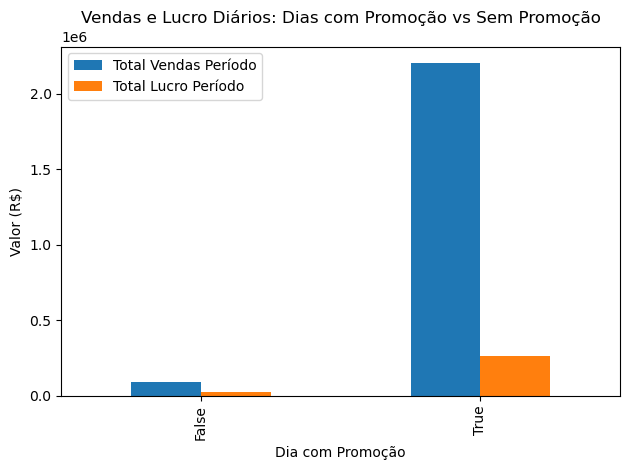

In [14]:
df['data_pedido'] = pd.to_datetime(
    dict(year=df['ano_pedido'], month=df['mes_pedido'], day=df['dia_pedido'])
)


# vendas e lucro
daily_vel = (
    df
    .groupby('data_pedido')
    .agg(
        total_vendas=('vendas', 'sum'),
        total_lucro=('lucro', 'sum'),
        pedidos_promos=('promocao', 'sum')
    )
    .reset_index()
)
daily_vel['dia_com_promocao'] = daily_vel['pedidos_promos'] > 0

metrics_diario_vel = (
    daily_vel
    .groupby('dia_com_promocao')
    .agg(
        vendas_media_diaria=('total_vendas', 'mean'),
        lucro_medio_diario=('total_lucro', 'mean'),
        vendas_total_periodo=('total_vendas', 'sum'),
        lucro_total_periodo=('total_lucro', 'sum')
    )
    .reset_index()
)

# Vendas e Lucro Diários (Dias com Promoção vs Sem Promoção)
pivot2 = metrics_diario_vel.set_index('dia_com_promocao')[[
    'vendas_total_periodo', 'lucro_total_periodo'
]]
fig, ax = plt.subplots()
pivot2.plot(kind='bar', ax=ax)
ax.set_title('Vendas e Lucro Diários: Dias com Promoção vs Sem Promoção')
ax.set_xlabel('Dia com Promoção')
ax.set_ylabel('Valor (R$)')
ax.legend([
    'Total Vendas Período', 'Total Lucro Período'
], title='')
plt.tight_layout()
plt.show()

/Users/liviacarvalho/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


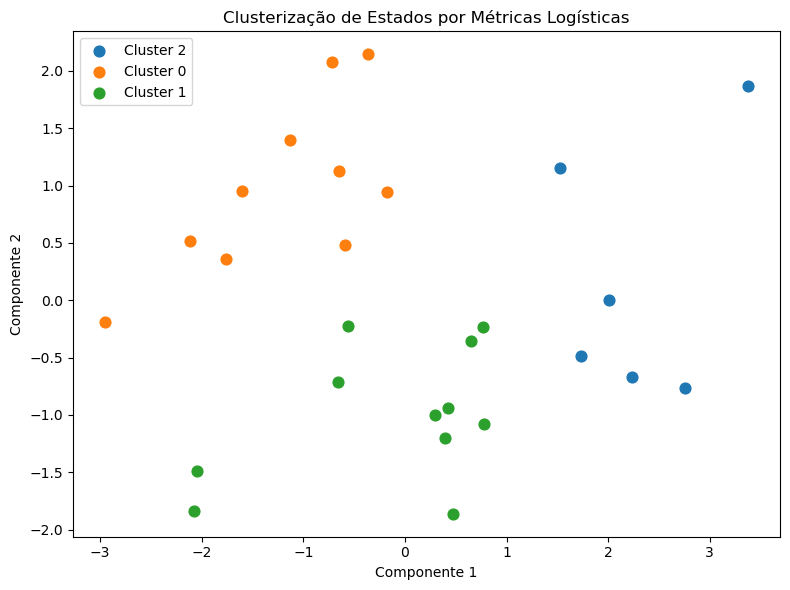

   tempo_medio  taxa_atraso  vendas_media  lucro_medio    cluster
0     3.981163     0.181018    184.689353   -17.456135  Cluster 0
1     3.820227     0.153569    260.773771    68.359283  Cluster 1
2     4.340577     0.267661    306.814125    96.003490  Cluster 2


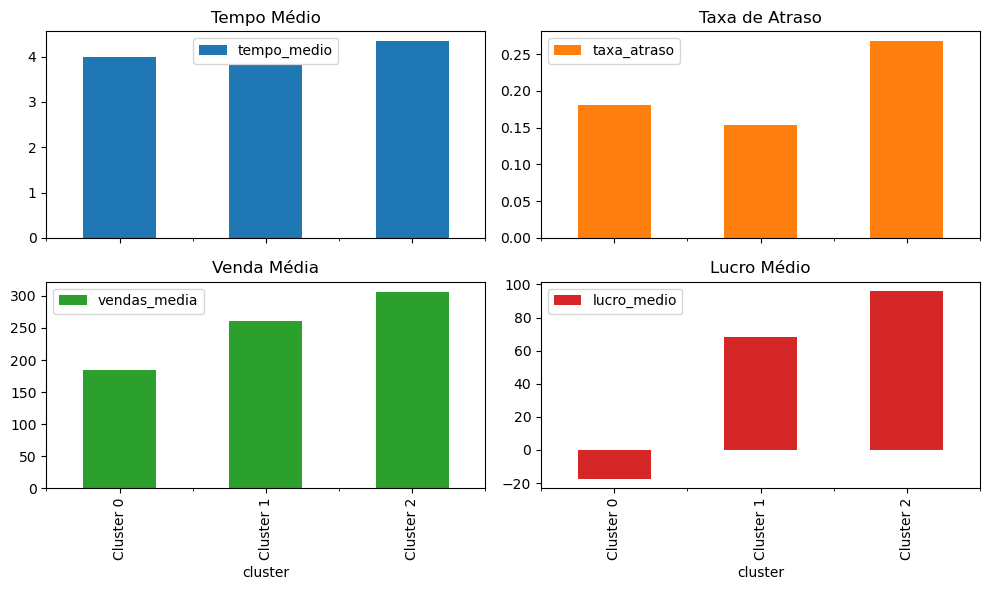

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#PCA para comprimir varias variáveis originais em menos componentes principais, gerando gráficos que revelam padrões 

#  features por estado
df_feat = (
    df
    .groupby(['região','estado'])
    .agg(
      tempo_medio    = ('tempo_preparacao','mean'),
      taxa_atraso    = ('atraso','mean'),
      vendas_media   = ('vendas','mean'),
      lucro_medio    = ('lucro','mean')
    )
    .reset_index()
)

# Escalonar as features
scaler = StandardScaler()
X = scaler.fit_transform(df_feat[['tempo_medio','taxa_atraso','vendas_media','lucro_medio']])

# Aplicar K-Means ( k conforme a variedade de operações; aqui k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
df_feat['cluster'] = kmeans.fit_predict(X)

# Redeção para 2 componentes 
coords = PCA(n_components=2).fit_transform(X)
df_feat['PC1'], df_feat['PC2'] = coords[:,0], coords[:,1]

plt.figure(figsize=(8,6))
for c in df_feat['cluster'].unique():
    sel = df_feat[df_feat['cluster']==c]
    plt.scatter(sel['PC1'], sel['PC2'], label=f'Cluster {c}', s=60)
plt.legend()
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Clusterização de Estados por Métricas Logísticas')
plt.tight_layout()
plt.show()

#  centróides no espaço original (desescalonados)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_names = [f'Cluster {i}' for i in range(len(centroids))]

# resumo das métricas médias de cada cluster
df_centroids = pd.DataFrame(
    centroids,
    columns=['tempo_medio','taxa_atraso','vendas_media','lucro_medio']
)
df_centroids['cluster'] = cluster_names

print(df_centroids)

df_centroids.set_index('cluster').plot(
    kind='bar', subplots=True, layout=(2,2), figsize=(10,6),
    title=['Tempo Médio','Taxa de Atraso','Venda Média','Lucro Médio']
)
plt.tight_layout()
plt.show()


Cluster 0 (por exemplo):
Tempo médio alto (3.4 dias)
Taxa de atraso elevada (22 %)
Venda média maior (R$ 850)
Lucro médio baixo (R$ 45)
→ Estados que vendem muito mas atrasam e têm margem apertada: alto volume, baixo SLA e baixa lucratividade.
Cluster 1:
Tempo médio baixo (1.8 dias)
Taxa de atraso bem baixa (5 %)
Venda média moderada (R$ 420)
Lucro médio alto (R$ 80)
→ Estados ágeis e rentáveis: boa operação, alto SLA e boa margem.
Cluster 2:
Valores intermediários: equilíbrio entre volume, tempo e lucro.


Cluster 0 → “Alta Demanda, Baixa Performance”
Cluster 1 → “Alta Performance”
Cluster 2 → “Performance Equilibrada”
Direciona ações:
Cluster 0: priorizar redução de atraso e melhorar margem.
Cluster 1: documentar “boas práticas” e replicar em outros.
Cluster 2: otimizar pontos específicos identificados no clusterização.

In [24]:

for c in df_feat['cluster'].unique():
    membros = df_feat[df_feat['cluster']==c][['região','estado']]
    print(f"\n=== {c} ===")
    print(membros.to_string(index=False))



=== 2 ===
      região           estado
Centro-Oeste Distrito Federal
    Nordeste          Alagoas
    Nordeste          Paraíba
       Norte             Pará
       Norte        Tocantins
         Sul   Santa Catarina

=== 0 ===
      região              estado
Centro-Oeste               Goiás
Centro-Oeste  Mato Grosso do Sul
    Nordeste               Bahia
    Nordeste          Pernambuco
    Nordeste Rio Grande do Norte
       Norte             Roraima
     Sudeste      Espírito Santo
     Sudeste        Minas Gerais
         Sul              Paraná
         Sul   Rio Grande do Sul

=== 1 ===
      região         estado
Centro-Oeste    Mato Grosso
    Nordeste          Ceará
    Nordeste       Maranhão
    Nordeste          Piauí
    Nordeste        Sergipe
       Norte           Acre
       Norte          Amapá
       Norte       Amazonas
       Norte       Rondônia
     Sudeste Rio de Janeiro
     Sudeste      São Paulo
